# UBS Feature Selection

In this section we will continute data preprocessing steps in order to facilitate feature selection critera

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

In [2]:
# read in full UBS dataset (2019 - 2022)
df = pd.read_csv("UBS_Cleaned_Date.csv")

In [3]:
# Change "date" column to ensure datetime type and drop weekends
df["date"] = pd.to_datetime(df["date"])

In [4]:
# Drop first 14 dates
df = df.iloc[14:-1, :].reset_index(drop = True)
df.shape

(796, 201)

In [5]:
# Remove any infinitly large or small values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [6]:
# Drop remanining NaN or null values
df = df.dropna()
df.shape

(748, 201)

In [7]:
# Create X feature dataset
X = df.drop(["date", "target_1", "target_2", "target_3", "target_4", "target_5"], axis=1)

# Create y target dataset
y = df["target_1"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Lasso Regression

Use lasso regression to find which features have coefficeints significantly different than zero. Those that are should be considered for inclusion in the models

In [9]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso())
])

search = GridSearchCV(pipeline,
                       {'model__alpha': np.arange(0.1, 10, 0.1)},
                        cv=10,
scoring = 'neg_mean_squared_error', verbose = 3
)

search.fit(X_train, y_train)
search.best_params_

coefficients = search.best_estimator_.named_steps['model'].coef_

importance = np.abs(coefficients)
importance

Fitting 10 folds for each of 99 candidates, totalling 990 fits
[CV 1/10] END ..............................model__alpha=0.1; total time=   1.3s
[CV 2/10] END ..............................model__alpha=0.1; total time=   0.1s
[CV 3/10] END ..............................model__alpha=0.1; total time=   0.0s
[CV 4/10] END ..............................model__alpha=0.1; total time=   0.0s
[CV 5/10] END ..............................model__alpha=0.1; total time=   0.0s
[CV 6/10] END ..............................model__alpha=0.1; total time=   0.0s
[CV 7/10] END ..............................model__alpha=0.1; total time=   0.0s
[CV 8/10] END ..............................model__alpha=0.1; total time=   0.0s
[CV 9/10] END ..............................model__alpha=0.1; total time=   0.1s
[CV 10/10] END .............................model__alpha=0.1; total time=   0.0s
[CV 1/10] END ..............................model__alpha=0.2; total time=   0.0s
[CV 2/10] END ..............................mo

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.16897186, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

### SelectKBest 

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# scale the data to be between 0 and 1. Chi2 doesn't allow for negative values


# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
best_fit = bestfeatures.fit(X, y)
best_scores = pd.DataFrame(best_fit.scores_)
best_columns = pd.DataFrame(X.columns)

# concatenate the dataframes for better visualization
features_score = pd.concat([best_columns, best_scores], axis=1)
features_score.columns = ['Features', 'Score']  # naming the dataframe columns
print(features_score.nlargest(10, 'Score'))  # print the top 10 best features

                    Features       Score
56              Change_Close  313.546149
66             Wiki_RSI_Move    7.953919
192       Dow_Disparity_Move    5.951264
59            Wiki_MAvg_Move    5.017463
154                 Nas_Move    4.581971
88                 Google_rs    4.294823
93           Google_ROC_Move    4.061060
160       Nas_Disparity_Move    3.780974
97   Google_Disparity_s_Move    3.778765
161     Nas_Disparity_s_Move    3.604700


/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


### Feature Importance with ExtraTreesClassifier

[5.82611286e-03 5.08624146e-04 2.61164964e-03 9.71577684e-05
 2.17752086e-03 3.82861193e-03 4.20329801e-03 4.51440408e-03
 4.11953595e-03 5.44567266e-03 1.49985330e-04 0.00000000e+00
 4.91875699e-03 5.62441532e-03 5.12504341e-03 5.14649180e-03
 4.09203904e-03 4.45089902e-03 3.99524731e-03 4.68218321e-03
 5.00862029e-03 4.17823243e-03 4.22898089e-03 4.61279350e-03
 3.95333950e-03 5.65078789e-03 5.04779550e-03 5.53540522e-03
 4.01138348e-03 3.73563805e-03 4.00675341e-03 5.00624427e-03
 5.23014860e-03 4.56602247e-03 4.82022747e-03 5.16900708e-03
 5.05925760e-03 5.57505102e-03 4.92816563e-03 4.57052482e-03
 5.07533049e-03 4.73217545e-03 5.20215217e-03 4.81003613e-03
 5.04807349e-03 5.37905072e-03 4.51792184e-03 5.21484468e-03
 3.86688237e-03 4.50723514e-03 4.27040128e-03 4.68557046e-03
 6.21483509e-03 6.88533678e-03 6.32711239e-03 5.44026906e-03
 5.93783532e-02 5.62439405e-03 3.93068818e-03 5.50572957e-03
 3.98538607e-03 5.60462560e-03 4.38494630e-03 4.15645122e-03
 4.84141984e-03 5.285299

<AxesSubplot:>

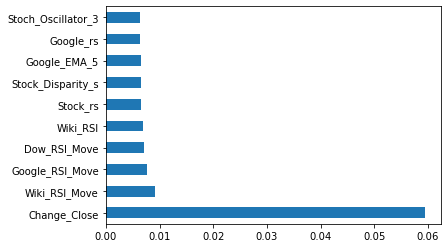

In [11]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X, y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')